# Atomic models with ASE

abTEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model structures. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as GPAW for running DFT simulations. Here we will introduce the features of ASE needed for image simulations; please refer to the ASE documentation for a general introduction.

## Atoms
The Atoms object defines a collection of atoms. Here is how to set up an $\mathrm{N}_2$ molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom):

In [1]:
from ase import Atoms
n2 = Atoms('2N', positions=[(0., 0., 0.), (0., 0., 1.10)], cell=[2, 2, 2])

abTEM uses just the positional coordinates, atomic numbers, and the unit cell properties for creating electrostatic potentials.

In [2]:
n2.positions

array([[0. , 0. , 0. ],
       [0. , 0. , 1.1]])

In [3]:
n2.numbers

array([7, 7])

In [4]:
n2.cell

Cell([2.0, 2.0, 2.0])

## Import

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>).

In [19]:
from ase.io import read
srtio3 = read('data/srtio3_100.cif')

## Visualize

The simplest way to visualize the atoms is the `view` function:

In [6]:
from ase.visualize import view
view(srtio3)

The atomic structure can be centered with the ASE `.center()` method and visualized inline in a Jupyter Notebook using the `show_atoms` function. This function shows a 2D projection of the structure perpendicular to the specified plane. For example:

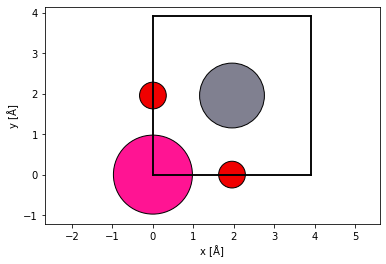

In [20]:
from abtem.plot import show_atoms

show_atoms(srtio3, plane='xy')

## Manipulation

abTEM always assumes that the imaging electrons propagate along the $z$-axis in the direction from negative to positive coordinate values. Hence, to choose the imaging zone axis, we need to manipulate the atoms so they are properly aligned.

ASE has a range of tools for manipulating imported structures, for example, the `surface` function, which is used for creating a periodic surface (aligned with the $z$-axis) with a given set of Miller indices.

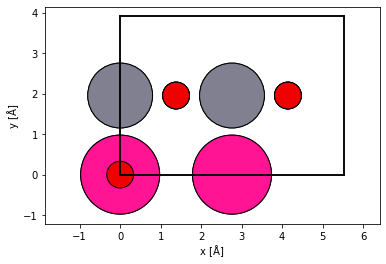

In [21]:
from ase.build import surface

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True)
#srtio3_110.center()

show_atoms(srtio3_110, plane='xy')

In [22]:
srtio3_110.cell

Cell([5.522503961066936, 3.905, 11.04500792213387])

Simulations may require a larger crystal, to repeat the atoms by two in the $x$- and by three in the $y$-direction (but not in the $z$-direction) we can write:

In [23]:
srtio3_110 *= (2, 3, 1)

Next, we center the atoms in the cell and add 3 Å of vacuum at the entrance and exit surfaces along the $z$-axis. Note that we visualize the structure now from the side, both along the $y$ and $x$ axes.

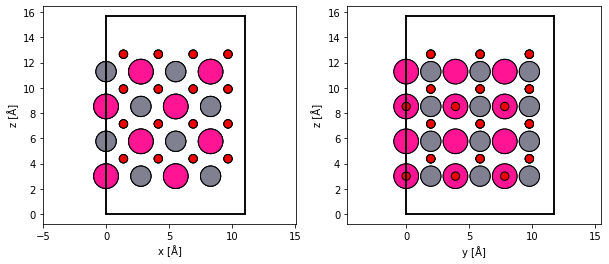

In [24]:
import matplotlib.pyplot as plt

srtio3_110.center(axis=2, vacuum=3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
show_atoms(srtio3_110, plane='xz', ax = ax1)
show_atoms(srtio3_110, plane='yz', ax = ax2)

The manipulated structure can also be exported to disk.

In [25]:
from ase.io import write

write('data/srtio3_110.cif', srtio3_110)

## Procedural creation

ASE also includes modules for procedurally generating special structures such as [carbon nanotubes](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes) and [nanoparticles](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html). Here we create a chirality $(6,0)$ nanotube (`length=1` here indicates the minimal commensurate unit cell along the tube axis).

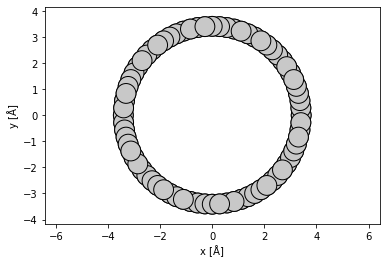

In [13]:
from ase.build import nanotube
cnt = nanotube(6, 4, length=1)

show_atoms(cnt)

As shown above, the electron propagation axis is along the length of the nanotube ($z$), which is probably not what you would like for an image simulation. To rotate the nanotube we use the ASE [rotate](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) method with the angle given in degrees and the rotation axis chosen to be $x$. Note that we also want to rotate the unit cell along with the structure.

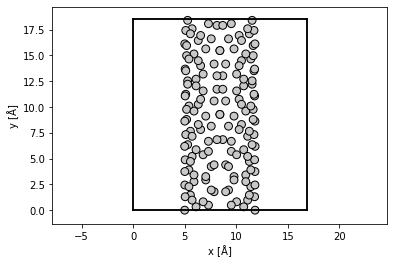

In [14]:
cnt.rotate(-90, 'x', rotate_cell=True)
cnt.center(vacuum=5, axis=(0,1))

show_atoms(cnt)

## General Bravais lattice

The ASE [lattice](https://wiki.fysik.dtu.dk/ase/ase/lattice.html) module provides a general framework for creating Atoms objects based on a Bravais lattice and a basis. Here we create a class for making graphene.

In [15]:
from ase.lattice.hexagonal import HexagonalFactory

class GrapheneFactory(HexagonalFactory):
    'A factory for creating graphene lattices.'
    xtal_name = 'graphene'
    bravais_basis = [[0, 0, 0], [1.0 / 3., 2.0 / 3.0, 0.]]

Graphene = GrapheneFactory()

graphene = Graphene('C', latticeconstant={'a' : 2.46, 'c' : 6})
graphene.center(axis=2)

The minimal unit cell of graphene is hexagonal, whereas the multislice algorithm requires an orthogonal unit cell. To make the unit cell orthogonal we can use the abTEM `orthogonalize_cell` function.  

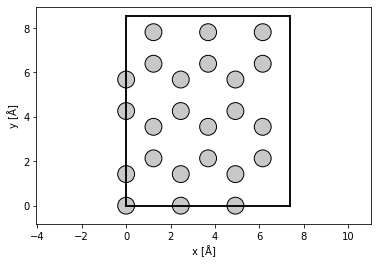

In [16]:
from abtem.structures import orthogonalize_cell

orthogonal_graphene = orthogonalize_cell(graphene)

orthogonal_graphene *= (3, 2, 1)

orthogonal_graphene.center(vacuum=3, axis=2)

show_atoms(graphene)